In [82]:
import os, json
import torch

DATA_PATH = 'data/trak'
size = 'large' # sizes: small (512x128), large (65536x13000)

train_path   = os.path.join(DATA_PATH, f'{size}_trak_train.json')
test_path    = os.path.join(DATA_PATH, f'{size}_trak_test.json')
scores_path  = os.path.join(DATA_PATH, f'{size}_attribution_scores.pt')
LIMIT = 100 # The large dataset has 85196800 examples

with open(train_path, 'r') as train_file:
    train_data = json.load(train_file)

with open(test_path, 'r') as test_file:
    test_data = json.load(test_file)

scores_data = torch.load(scores_path)

# Softmax the last dimension of the scores
scores_norm = scores_data.permute(2, 1, 0).contiguous()
scores_norm = scores_norm.view(scores_norm.size(0), -1)
scores_norm = torch.nn.functional.softmax(scores_norm, dim=1)
scores_norm = scores_norm.permute(1, 0)
scores_data = scores_norm.view(scores_data.size())

pairs_list = []

input_text  = [entry['input_text'] for entry in train_data]
labels_text = [entry['labels_text'] for entry in train_data]
test_text   = [entry['input_text'] for entry in test_data]

print(f'Loaded data: \n  Train data of {len(train_data)} documents\n  Test data of {len(test_data)} examples\n  Scores file of shape {scores_data.shape}')
count = 0
for train_idx, _ in enumerate(train_data):
    labels = labels_text[train_idx]
    for token_idx, _ in enumerate(labels):
        for test_idx, _ in enumerate(test_data):
            pairs_list += [(
                input_text[train_idx],
                labels_text[train_idx][token_idx],
                test_text[test_idx],
                scores_data[train_idx, token_idx, test_idx].item()
            )]

            # If a LIMIT is specified, only return the first LIMIT examples
            if LIMIT and count > LIMIT: break
            count += 1

Loaded data: 
  Train data of 396 documents
  Test data of 1300 examples
  Scores file of shape torch.Size([396, 236, 13000])


In [104]:
# Sanity check for softmax
mmlu_example = scores_data[:, :, 0]
torch.sum(torch.where(mmlu_example == float('-inf'), torch.zeros_like(mmlu_example), mmlu_example))

tensor(1.0000)

In [ ]:
import matplotlib.pyplot as plt

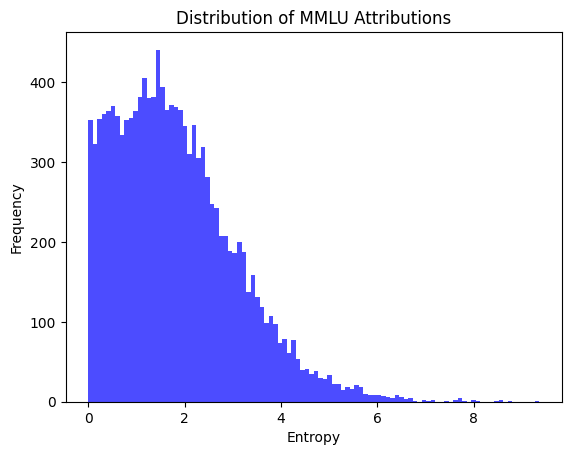

In [116]:
entropy = []

for i in range(scores_data.shape[2]):
    mmlu_example = scores_data[:, :, i]
    mmlu_example = mmlu_example.flatten()
    mmlu_example = mmlu_example[mmlu_example != 0]
    entropy += [-torch.sum(mmlu_example * torch.log2(mmlu_example)).item()]

plt.hist(entropy, bins=100, alpha=0.7, color='blue')
plt.title('Distribution of MMLU Attributions')
plt.xlabel('Entropy')
plt.ylabel('Frequency')
plt.show()

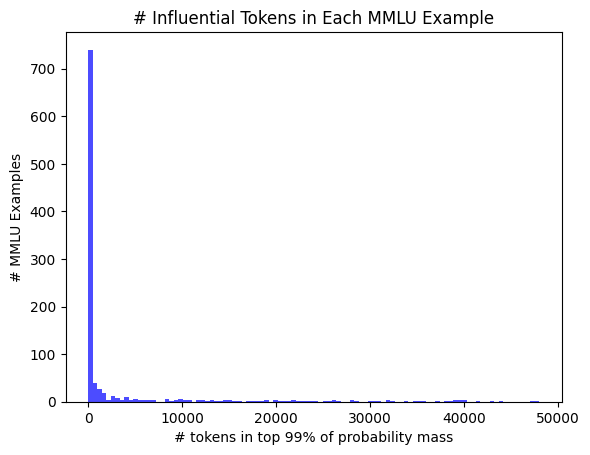

In [150]:
def num_top_elems(tensor, threshold=0.99):
    sorted, _ = torch.sort(tensor, descending=True)
    cumsum = torch.cumsum(sorted, dim=0)
    thresh = torch.nonzero(cumsum >= threshold, as_tuple=False)[0]
    return thresh.item() + 1

thresholds = []
for i in range(1000): # scores_data.shape[2]
    mmlu_example = scores_data[:, :, i].flatten()
    mmlu_example = mmlu_example[mmlu_example != 0]
    thresholds += [num_top_elems(mmlu_example)]

plt.hist(thresholds, bins=100, alpha=0.7, color='blue')
plt.title('# Influential Tokens in Each MMLU Example')
plt.xlabel('# tokens in top 99% of probability mass')
plt.ylabel('# MMLU Examples')
plt.show()

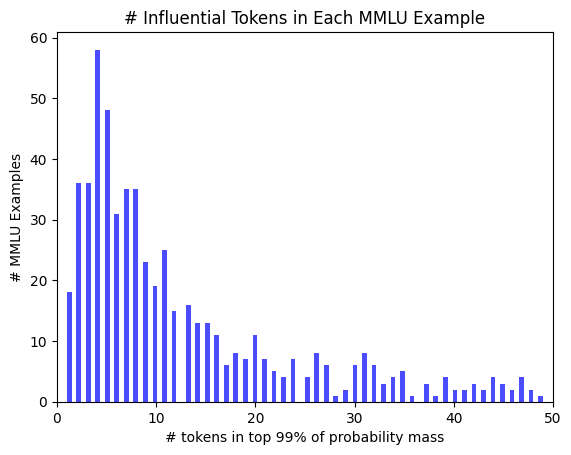

In [162]:
# Let's zoom in on this figure

plt.hist([t for t in thresholds if t < 50], bins=100, alpha=0.7, color='blue')
plt.title('# Influential Tokens in Each MMLU Example')
plt.xlabel('# tokens in top 99% of probability mass')
plt.ylabel('# MMLU Examples')
plt.xlim(0, 50)
plt.show()